In [ ]:
import os
os.chdir('/content/drive/MyDrive')

## Geometry of Einstein Tile
This section contains the geometry and transformation of a unit Einstein Tile. It is also refered to as 'HatTile' due to its special shape.

In [2]:
import math
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection


# some useful constant
r3 = math.sqrt(3)
hr3 = math.sqrt(3)/2
ident = [1, 0, 0, 0, 1, 0]

# customised dictionary to change filling and edge colors
cols = {
      'H1' : [153/255, 100/255, 1],
      'H' : [229/255, 205/255, 1],
      'T' : [224/255, 224/255, 224/255],
      'P' : [250/255, 250/255, 250/255],
      'F' : [255/255, 255/255, 198/255],
      'edge': [0, 0, 0]
       }

# create vertex
def pt(x, y):
    return {'x': x, 'y': y}

# corresponding hexagonal vertices on a flat-topped hexagonal grid
def hexPt(x, y):
    return pt(x + 0.5*y, hr3*y)

# affine transform matrix inversion
def inv(T):
    det = T[0]*T[4] - T[1]*T[3]
    return [T[4]/det, -T[1]/det, (T[1]*T[5]-T[2]*T[4])/det,
            -T[3]/det, T[0]/det, (T[2]*T[3]-T[0]*T[5])/det]

# affine transform matrix multiplication
def mul(A, B):
    return [A[0]*B[0] + A[1]*B[3], 
            A[0]*B[1] + A[1]*B[4],
            A[0]*B[2] + A[1]*B[5] + A[2],

            A[3]*B[0] + A[4]*B[3], 
            A[3]*B[1] + A[4]*B[4],
            A[3]*B[2] + A[4]*B[5] + A[5]]

# add vertices
def padd(p, q):
    return {'x': p['x'] + q['x'], 'y': p['y'] + q['y']}

# subtract vertices
def psub(p, q):
    return {'x': p['x'] - q['x'], 'y': p['y'] - q['y']}

# rotate matrix
def trot(ang):
    c = math.cos(ang)
    s = math.sin(ang)
    return [c, -s, 0, s, c, 0]

# transport matrix
def ttrans(tx, ty):
    return [1, 0, tx, 0, 1, ty]

# rotate vertex by an angle
def rotAbout(p, ang):
    return mul(ttrans(p['x'], p['y']), mul(trot(ang), ttrans(-p['x'], -p['y'])))

# Affine transport of vertex
def transPt(M, P):
    return pt(M[0]*P['x'] + M[1]*P['y'] + M[2], M[3]*P['x'] + M[4]*P['y'] + M[5])

# linear transform matrix, map (0,0) -> p and (1,0) -> q
def matchSeg(p, q):
    return [q['x']-p['x'], p['y']-q['y'], p['x'], q['y']-p['y'], q['x']-p['x'], p['y']]

# linear transform: map p1 -> p2, q1 -> q2
def matchTwo(p1, q1, p2, q2):
    return mul(matchSeg(p2, q2), inv(matchSeg(p1, q1)))

# return the intersection point of the segments connecting p1,q1 and p2,q2
def intersect(p1, q1, p2, q2):
    d = (q2['y'] - p2['y']) * (q1['x'] - p1['x']) - (q2['x'] - p2['x']) * (q1['y'] - p1['y'])
    uA = ((q2['x'] - p2['x']) * (p1['y'] - p2['y']) - (q2['y'] - p2['y']) * (p1['x'] - p2['x'])) / d
    uB = ((q1['x'] - p1['x']) * (p1['y'] - p2['y']) - (q1['y'] - p1['y']) * (p1['x'] - p2['x'])) / d
    return pt(p1['x'] + uA * (q1['x'] - p1['x']), p1['y'] + uA * (q1['y'] - p1['y']))

# create a 'hat'
hat_outline = [
    hexPt(0, 0), hexPt(-1,-1), hexPt(0,-2), hexPt(2,-2),
    hexPt(2,-1), hexPt(4,-2), hexPt(5,-1), hexPt(4, 0),
    hexPt(3, 0), hexPt(2, 2), hexPt(0, 3), hexPt(0, 2),
    hexPt(-1, 2)]

H_outline = [pt(0, 0), pt(4, 0), pt(4.5, hr3),
              pt(2.5, 5 * hr3), pt(1.5, 5 * hr3), pt(-0.5, hr3)]

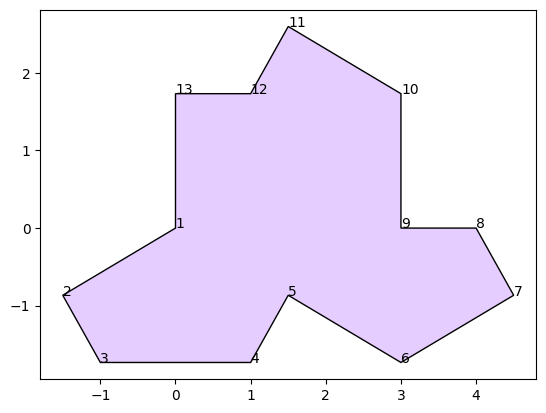

In [3]:
# plot the 'hat'

# generate a subplot, with figure and ax variables
fig, ax = plt.subplots()
x_coords = [p['x'] for p in hat_outline]
y_coords = [p['y'] for p in hat_outline]

# plot the hat, can customise facecolor, edgecolor, and linewidth
ax.fill(x_coords, y_coords, facecolor=cols['H'], edgecolor=cols['edge'])

# annotate every vertices in the hat polygon
for i in range(len(hat_outline)):
    plt.annotate(str(i+1), (x_coords[i], y_coords[i]))

plt.show()

## HatTile and MetaTile class
The HatTile is a class containing 5 different unit Tiles. They share the same shape (hat-shape), and we only use different labels to strengthen the fact that they belong to different MetaTile. Tiles in each MetaTile will be colored differently. The first MetaTile is multi-colored and the rest are monochromatic.

A MetaTile is a finite ensemble of unit Tiles, equipped with a bigger geometric shape (triangle, parallelogram, etc.). There are four types of MetaTile, and we will construct aperiodic Tiling based on these MetaTiles.

In [4]:
# mpl.rcParams['lines.linewidth'] = 0.01

# draw one hat, need to create fig and ax variables beforehead
def drawPolygon(shape, T, f=cols['H'], e=cols['edge']):
  polygon = [transPt(T, p) for p in shape]
  ax.fill([p['x'] for p in polygon], [p['y'] for p in polygon], 
          facecolor=f, edgecolor=e, linewidth = 1)
  return

# unit Tiles
class HatTile:
    def __init__(self, label):
        # 5 types of labels in total, determine filling color using cols dictionary
        self.label = label

    def draw(self, S, level):
        # hat_outline: a pre-defined basic Hat Tile,
        # S: transform matrix
        drawPolygon(hat_outline, S, cols[self.label], cols['edge'])
        return

# ensemble Tiles
class MetaTile:
    def __init__(self, shape, width):
        self.shape = shape # four ensemble shapes, as plotted below
        self.width = width
        self.children = [] # sub-metaTile or unit Tile in ensemble

    def addChild(self, T, geom):
        # T: transform matrix
        # geom: HatTile type
        self.children.append({'T': T, 'geom': geom})
        return

    def evalChild(self, n, i):
        # get the i-th vertex in the n-th child
        return transPt(self.children[n]['T'], self.children[n]['geom'].shape[i])

    def draw(self, S, level):
        # draw all the ensemble Tiles
        if level > 0:
            for g in self.children:
              g['geom'].draw(mul(S, g['T']), level - 1)
        else:
            drawPolygon(self.shape, S, None, 'black')
        return

    def recentre(self):
        # recenter all the ensemble Tiles
        cx = 0
        cy = 0
        for p in self.shape:
            cx += p['x']
            cy += p['y']
        cx /= len(self.shape)
        cy /= len(self.shape)
        tr = pt(-cx, -cy)

        for idx in range(len(self.shape)):
            self.shape[idx] = padd(self.shape[idx], tr)

        M = ttrans(-cx, -cy)
        for ch in self.children:
            ch['T'] = mul(M, ch['T'])
        return

## Unit and ensemble tiles initialisation

Here we initialise four different MetaTiles, which will be used later. We plotted them explicitly for your information.

In [5]:
# initialize 5 unit tiles
H1_hat = HatTile('H1')
H_hat = HatTile('H')
T_hat = HatTile('T')
P_hat = HatTile('P')
F_hat = HatTile('F')

In [6]:
def H_init():
    H_outline = [pt(0, 0), pt(4, 0), pt(4.5, hr3), pt(2.5, 5 * hr3), pt(1.5, 5 * hr3), pt(-0.5, hr3), pt(0, 0)]
    meta = MetaTile(H_outline, 2)

    meta.addChild(matchTwo(hat_outline[5], hat_outline[7], H_outline[5], H_outline[0]), H_hat)
    meta.addChild(matchTwo(hat_outline[9], hat_outline[11], H_outline[1], H_outline[2]), H_hat)
    meta.addChild(matchTwo(hat_outline[5], hat_outline[7], H_outline[3], H_outline[4]), H_hat)
    meta.addChild(mul(ttrans(2.5, hr3), mul([-0.5,-hr3,0,hr3,-0.5,0], [0.5,0,0,0,-0.5,0])), H1_hat) # the middle one

    return meta

H_init = H_init()

def T_init():
    T_outline = [pt(0, 0), pt(3, 0), pt(1.5, 3 * hr3)]
    meta = MetaTile(T_outline, 2)
    
    meta.addChild([0.5, 0, 0.5, 0, 0.5, hr3], T_hat)

    return meta

T_init = T_init()

def P_init():
    P_outline = [pt(0, 0), pt(4, 0), pt(3, 2 * hr3), pt(-1, 2 * hr3)]
    meta = MetaTile(P_outline, 2)

    meta.addChild([0.5, 0, 1.5, 0, 0.5, hr3], P_hat)
    meta.addChild(mul(ttrans(0, 2 * hr3), mul([0.5, hr3, 0, -hr3, 0.5, 0], [0.5, 0.0, 0.0, 0.0, 0.5, 0.0])), P_hat)

    return meta

P_init = P_init()

def F_init():
    F_outline = [pt(0, 0), pt(3, 0), pt(3.5, hr3), pt(3, 2 * hr3), pt(-1, 2 * hr3)]
    meta = MetaTile(F_outline, 2)

    meta.addChild([0.5, 0, 1.5, 0, 0.5, hr3], F_hat)
    meta.addChild(mul(ttrans(0, 2 * hr3), mul([0.5, hr3, 0, -hr3, 0.5, 0], [0.5, 0.0, 0.0, 0.0, 0.5, 0.0])), F_hat)

    return meta

F_init = F_init()

### some demos for different meta patterns

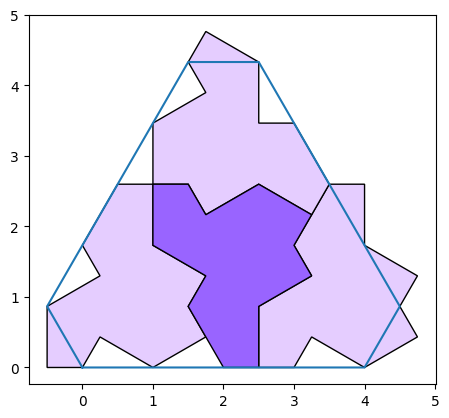

In [142]:
# pattern H
H_outline = [pt(0, 0), pt(4, 0), pt(4.5, hr3), pt(2.5, 5 * hr3), pt(1.5, 5 * hr3), pt(-0.5, hr3), pt(0, 0)]

T1 = matchTwo(hat_outline[5], hat_outline[7], H_outline[5], H_outline[0])
T2 = matchTwo(hat_outline[9], hat_outline[11], H_outline[1], H_outline[2])
T3 = matchTwo(hat_outline[5], hat_outline[7], H_outline[3], H_outline[4])
T4 = mul(ttrans(2.5, hr3), mul([-0.5,-hr3,0,hr3,-0.5,0], [0.5,0,0,0,-0.5,0]))

fig, ax = plt.subplots()

for i in range(4): 
  T = [T1, T2, T3, T4][i]
  new_points = [transPt(T, pt) for pt in hat_outline]
  new_x = [p['x'] for p in new_points]
  new_y = [p['y'] for p in new_points]
  if i == 3:
    drawPolygon(hat_outline, T, cols['H1'], cols['edge'])
  else:
    drawPolygon(hat_outline, T, cols['H'], cols['edge'])

ax.plot([p['x'] for p in H_outline], [p['y'] for p in H_outline])
ax.set_aspect('equal', adjustable='box')
plt.show()

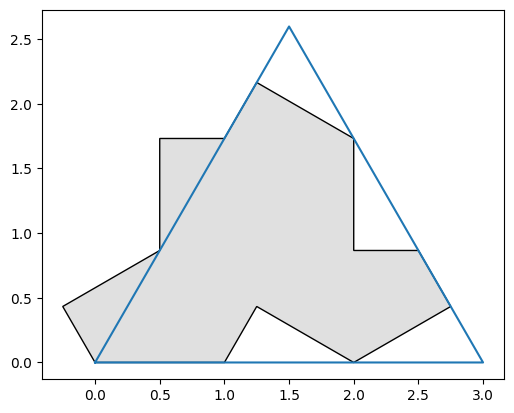

In [143]:
T_outline = [pt(0, 0), pt(3, 0), pt(1.5, 3 * hr3), pt(0, 0)]

fig, ax = plt.subplots()

T5 = [0.5, 0, 0.5, 0, 0.5, hr3]
new_points = [transPt(T5, pt) for pt in hat_outline]
new_x = [p['x'] for p in new_points]
new_y = [p['y'] for p in new_points]

drawPolygon(hat_outline, T5, cols['T'], cols['edge'])
plt.plot([p['x'] for p in T_outline], [p['y'] for p in T_outline])
ax.set_aspect('equal', adjustable='box')
plt.show()

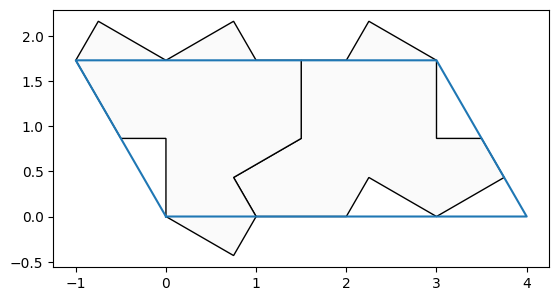

In [144]:
P_outline = [pt(0, 0), pt(4, 0), pt(3, 2 * hr3), pt(-1, 2 * hr3), pt(0, 0)]
T6 = [0.5, 0, 1.5, 0, 0.5, hr3]
T7 = mul(ttrans(0, 2 * hr3), mul([0.5, hr3, 0, -hr3, 0.5, 0], [0.5, 0.0, 0.0, 0.0, 0.5, 0.0]))

fig, ax = plt.subplots()

for i in range(2): 
  T = [T6,T7][i]
  new_points = [transPt(T, pt) for pt in hat_outline]
  new_x = [p['x'] for p in new_points]
  new_y = [p['y'] for p in new_points]
  drawPolygon(hat_outline, T, cols['P'], cols['edge'])
ax.plot([p['x'] for p in P_outline], [p['y'] for p in P_outline])
ax.set_aspect('equal', adjustable='box')
plt.show()

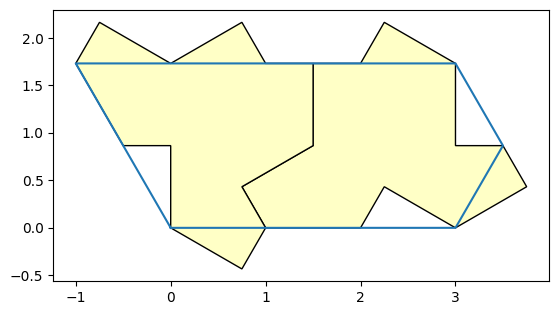

In [145]:
F_outline = [pt(0, 0), pt(3, 0), pt(3.5, hr3), pt(3, 2 * hr3), pt(-1, 2 * hr3), pt(0, 0)]
T8 = [0.5, 0, 1.5, 0, 0.5, hr3]
T9 = mul(ttrans(0, 2 * hr3), mul([0.5, hr3, 0, -hr3, 0.5, 0], [0.5, 0.0, 0.0, 0.0, 0.5, 0.0]))

fig, ax = plt.subplots()

for i in range(2): 
  T = [T8,T9][i]
  new_points = [transPt(T, pt) for pt in hat_outline]
  new_x = [p['x'] for p in new_points]
  new_y = [p['y'] for p in new_points]
  drawPolygon(hat_outline, T, cols['F'], cols['edge'])
plt.plot([p['x'] for p in F_outline], [p['y'] for p in F_outline])
ax.set_aspect('equal', adjustable='box')
plt.show()

## Construct Patch and Metatiles

The 'constructPatch' function uses four types of MetaTiles to construct an aperiodic patch. There are fixed rules (not unique!) to generate a patch using these MetaTiles.

The MetaTiles consist of either several unit Tiles or other smaller MetaTiles. Based on self-similarity of our tiling, we could subdivide the MetaTiles infinitely into smaller MetaTiles (there are four types of MetaTiles on each level) to create aperiodic tiling on a larger scale.

The subdivision of MetaTile is done in 'constructMetatiles'.

In [7]:
def constructPatch(H, T, P, F):
    # define rules to construct an aperiodic patch
    # bigger patch can be construct basing on self-similarity
    rules = [
        ['H'],
        [0, 0, 'P', 2],
        [1, 0, 'H', 2],
        [2, 0, 'P', 2],
        [3, 0, 'H', 2],
        [4, 4, 'P', 2],
        [0, 4, 'F', 3],
        [2, 4, 'F', 3],
        [4, 1, 3, 2, 'F', 0],
        [8, 3, 'H', 0],
        [9, 2, 'P', 0],
        [10, 2, 'H', 0],
        [11, 4, 'P', 2],
        [12, 0, 'H', 2],
        [13, 0, 'F', 3],
        [14, 2, 'F', 1],
        [15, 3, 'H', 4],
        [8, 2, 'F', 1], 
        [17, 3, 'H', 0],
        [18, 2, 'P', 0],
        [19, 2, 'H', 2],
        [20, 4, 'F', 3],
        [20, 0, 'P', 2],
        [22, 0, 'H', 2],
        [23, 4, 'F', 3],
        [23, 0, 'F', 3],
        [16, 0, 'P', 2],
        [9, 4, 0, 2, 'T', 2],
        [4, 0, 'F', 3]
    ]

    ret = MetaTile([], H.width)
    shapes = {'H': H, 'T': T, 'P': P, 'F': F}

    # apply affine transformation to ensemble Tiles to obtain a patch
    for r in rules:
        if len(r) == 1:
            ret.addChild(ident, shapes[r[0]])
        elif len(r) == 4:
            poly = ret.children[r[0]]['geom'].shape
            T = ret.children[r[0]]['T']
            P = transPt(T, poly[(r[1]+1)%len(poly)])
            Q = transPt(T, poly[r[1]])
            nshp = shapes[r[2]]
            npoly = nshp.shape

            ret.addChild(
                matchTwo(npoly[r[3]], npoly[(r[3]+1)%len(npoly)], P, Q),
                nshp
            )
        else:
            chP = ret.children[r[0]]
            chQ = ret.children[r[2]]

            P = transPt(chQ['T'], chQ['geom'].shape[r[3]])
            Q = transPt(chP['T'], chP['geom'].shape[r[1]])
            nshp = shapes[r[4]]
            npoly = nshp.shape

            ret.addChild(
                matchTwo(npoly[r[5]], npoly[(r[5]+1)%len(npoly)], P, Q),
                nshp
            )
        
    return ret

In [8]:
PI = math.pi

def constructMetatiles(patch):
    bps1 = patch.evalChild(8, 2)
    bps2 = patch.evalChild(21, 2)
    rbps = transPt(rotAbout(bps1, -2.0*PI/3.0), bps2)

    p72 = patch.evalChild(7, 2)
    p252 = patch.evalChild(25, 2)

    llc = intersect(bps1, rbps, patch.evalChild(6, 2), p72)
    w = psub(patch.evalChild(6, 2), llc)

    new_H_outline = [llc, bps1]
    w = transPt(trot(-PI/3), w)
    new_H_outline.append(padd(new_H_outline[1], w))
    new_H_outline.append(patch.evalChild(14, 2))
    w = transPt(trot(-PI/3), w)
    new_H_outline.append(psub(new_H_outline[3], w))
    new_H_outline.append(patch.evalChild(6, 2))

    new_H = MetaTile(new_H_outline, patch.width * 2)
    for ch in [0, 9, 16, 27, 26, 6, 1, 8, 10, 15]:
        new_H.addChild(patch.children[ch]['T'], patch.children[ch]['geom'])

    new_P_outline = [p72, padd(p72, psub(bps1, llc)), bps1, llc]
    new_P = MetaTile(new_P_outline, patch.width * 2)
    for ch in [7, 2, 3, 4, 28]:
        new_P.addChild(patch.children[ch]['T'], patch.children[ch]['geom'])

    new_F_outline = [
        bps2, patch.evalChild(24, 2), patch.evalChild(25, 0),
        p252, padd(p252, psub(llc, bps1))
    ]
    new_F = MetaTile(new_F_outline, patch.width * 2)
    for ch in [21, 20, 22, 23, 24, 25]:
        new_F.addChild(patch.children[ch]['T'], patch.children[ch]['geom'])

    AAA = new_H_outline[2]
    BBB = padd(new_H_outline[1], psub(new_H_outline[4], new_H_outline[5]))
    CCC = transPt(rotAbout(BBB, -PI/3), AAA)
    new_T_outline = [BBB, CCC, AAA]
    new_T = MetaTile(new_T_outline, patch.width * 2)
    new_T.addChild(patch.children[11]['T'], patch.children[11]['geom'])

    new_H.recentre()
    new_P.recentre()
    new_F.recentre()
    new_T.recentre()

    return [new_H, new_T, new_P, new_F]

## Test Result

Based on the simplest group of MetaTiles (plotted above), we could construct a patch (following the rules) and higher level MetaTiles. The following blocks show how we could do such construction iteratively using the self-similrity of the Einstein Tiling.

to download images plotted below, 

*   connect the colab notebook to google drive,
*   increase the figsize and dpi in `plt.figure()`,
*   comment `plt.show()` and add the following two lines:
```
plt.axis('off')
plt.savefig('tiles1.png', bbox_inches='tight')
```

### level-1 *Patches* and *MetaTiles*

We use basic (level-0) MetaTiles as input to construct level-1 patch and level-1 MetaTiles.

In [ ]:
tiles0 = [H_init, T_init, P_init, F_init] # basic (level-0) MetaTiles
patch1 = constructPatch(*tiles0) # construct level-1 patch
tiles1 = constructMetatiles(patch1) # construct level-1 MetaTiles

#### level-1 Patch

Based on the rules we pre-defined in `constructPatch`, we get a bigger patch (which is deterministic according to the rules). One could change the rules to construct different, bigger, or even random patch! However, the determinisity of the rules we used will not change its aperiodicity.

You could:
*   change `to_screen` to increase/decrease Tile size;
*   change `patch1.draw(level)` to 1 to see how the patch is constructed from four types of basic MetaTiles. (one polygon represents one MetaTile)



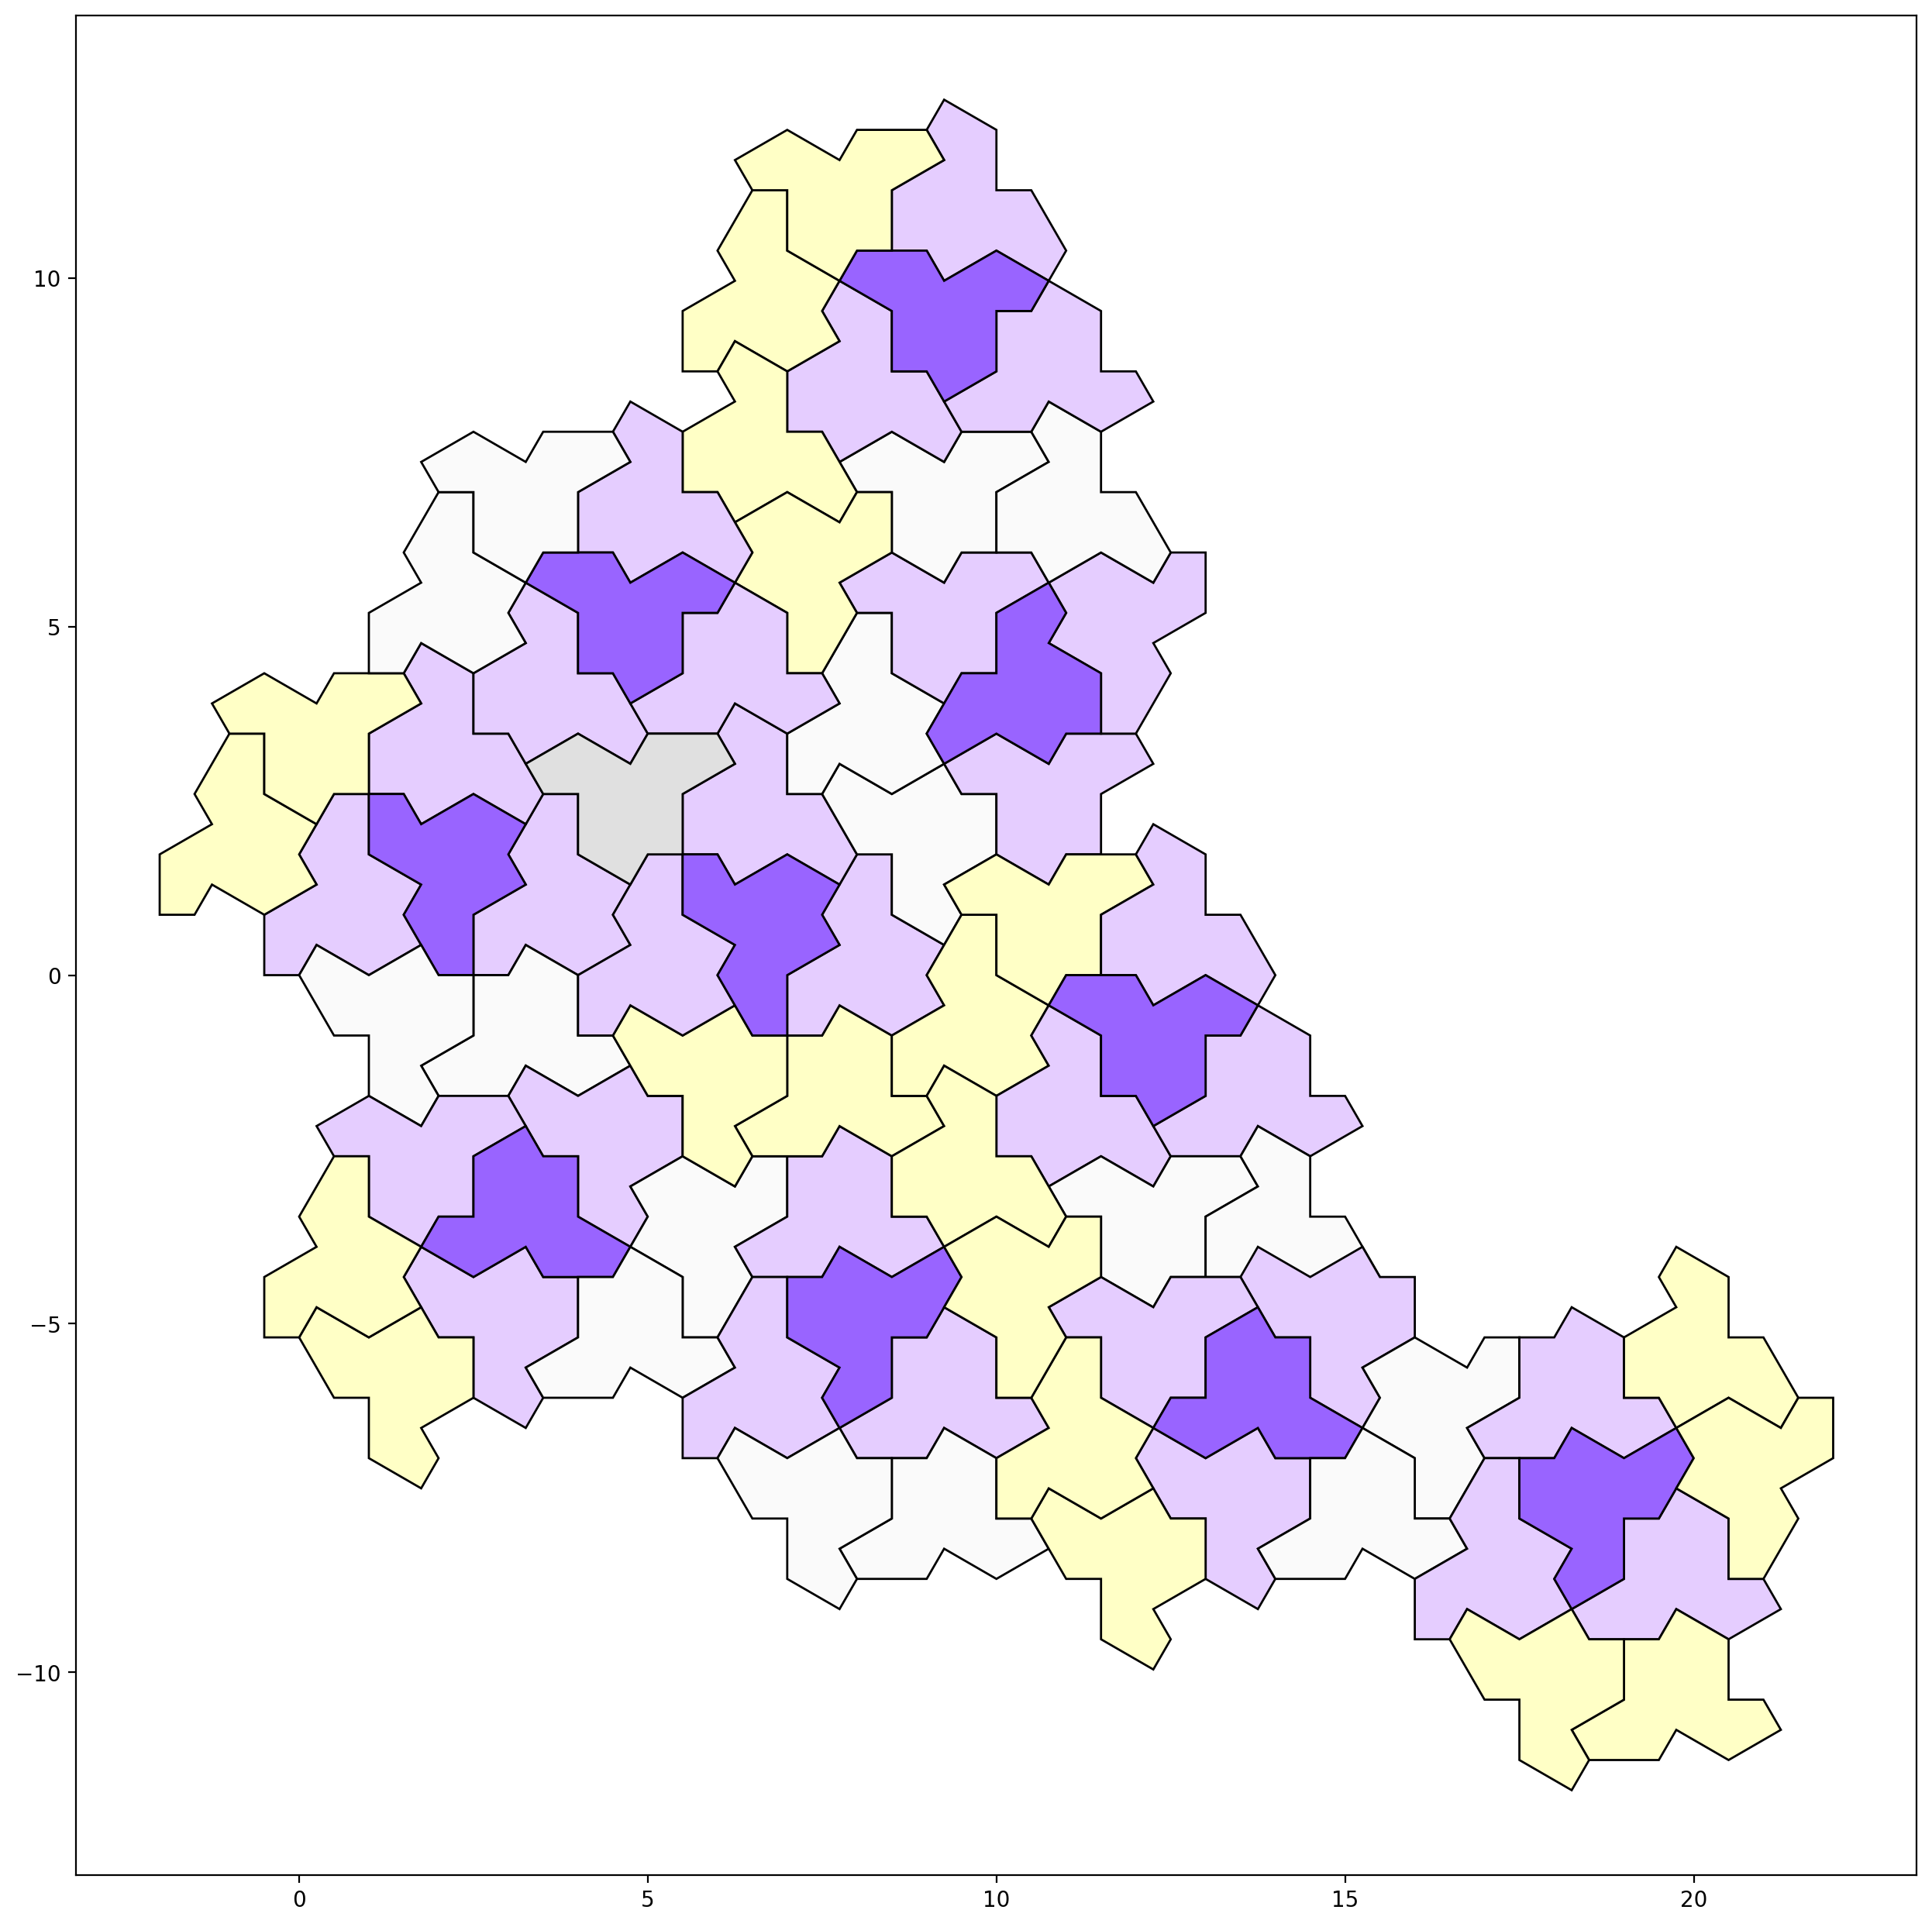

In [61]:
fig = plt.figure(figsize=(16, 12), dpi=200)
ax = fig.add_axes([0, 0, 1, 1])
to_screen = [1, 0, 0, 0, 1, 0]
patch1.draw(to_screen, level=2)
ax.set_aspect('equal', adjustable='box')
plt.show()

#### level-1 MetaTiles
You could:

*  specify `level=0` to see the structure of MetaTile at current level,

*  specify `level=1` to see how level-1 MetaTiles are constructed from level-0 MetaTiles,

*  specify `level=2` to see how level-1 MetaTiles are constructed from unit Tiles,

*  use `tiles1[0,1,2,3]` to explore different types (H, T, P, F) of level-1 MetaTiles!



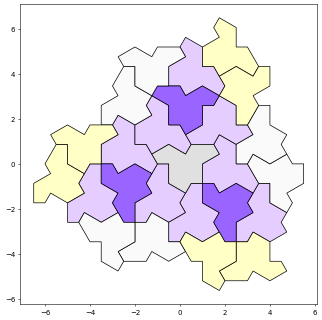

In [38]:
# MetaTile H
fig = plt.figure(figsize=(8, 6), dpi=50)
ax = fig.add_axes([0, 0, 1, 1])
tiles1[0].draw(to_screen, level=2)
ax.set_aspect('equal', adjustable='box')

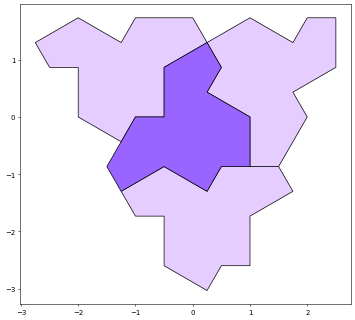

In [29]:
# MetaTile T
fig = plt.figure(figsize=(8, 6), dpi=50)
ax = fig.add_axes([0, 0, 1, 1])
tiles1[1].draw(to_screen, level=2)
ax.set_aspect('equal', adjustable='box')

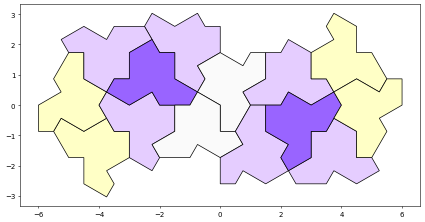

In [30]:
# MetaTile P
fig = plt.figure(figsize=(8, 6), dpi=50)
ax = fig.add_axes([0, 0, 1, 1])
tiles1[2].draw(to_screen, level=2)
ax.set_aspect('equal', adjustable='box')

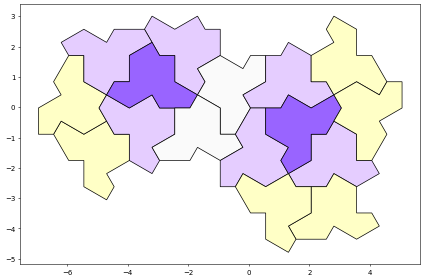

In [31]:
# MetaTile F
fig = plt.figure(figsize=(8, 6), dpi=50)
ax = fig.add_axes([0, 0, 1, 1])
tiles1[3].draw(to_screen, level=2)
ax.set_aspect('equal', adjustable='box')

### level-2 Patches and MetaTiles

Now based on the level-1 MetaTiles, we construct level-2 patch and level-2 MetaTiles.

In [53]:
patch2 = constructPatch(*tiles1) # we use tiles1 instead of tiles0
tiles2 = constructMetatiles(patch2)

#### level-2 patch

In [60]:
fig = plt.figure(figsize=(32, 24), dpi=200)
ax = fig.add_axes([0, 0, 1, 1])
to_screen = [1, 0, 0, 0, 1, 0]
patch2.draw(to_screen, level=3)
ax.set_aspect('equal', adjustable='box')
plt.show()

Output hidden; open in https://colab.research.google.com to view.

#### level-2 MetaTiles

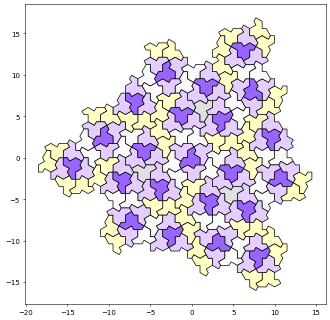

In [54]:
# MetaTile H
fig = plt.figure(figsize=(8, 6), dpi=50)
ax = fig.add_axes([0, 0, 1, 1])
tiles2[0].draw(to_screen, level=3)
ax.set_aspect('equal', adjustable='box')

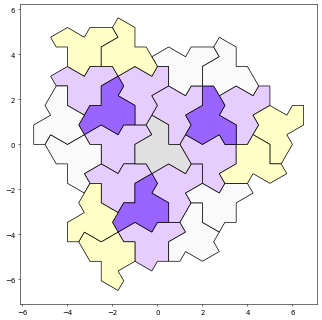

In [55]:
# MetaTile T
fig = plt.figure(figsize=(8, 6), dpi=50)
ax = fig.add_axes([0, 0, 1, 1])
tiles2[1].draw(to_screen, level=3)
ax.set_aspect('equal', adjustable='box')

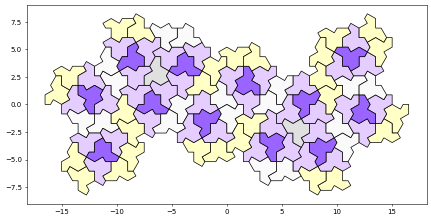

In [56]:
# MetaTile P
fig = plt.figure(figsize=(8, 6), dpi=50)
ax = fig.add_axes([0, 0, 1, 1])
tiles2[2].draw(to_screen, level=3)
ax.set_aspect('equal', adjustable='box')

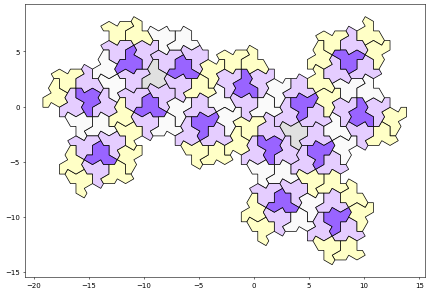

In [57]:
# MetaTile F
fig = plt.figure(figsize=(8, 6), dpi=50)
ax = fig.add_axes([0, 0, 1, 1])
tiles2[3].draw(to_screen, level=3)
ax.set_aspect('equal', adjustable='box')

### level-3  Patches and MetaTiles

Again based on the level-2 MetaTiles, we construct level-3 patch and level-3 MetaTiles.

In [59]:
patch3 = constructPatch(*tiles2)
tiles3 = constructMetatiles(patch3)

#### level-3 patch

In [62]:
fig = plt.figure(figsize=(64, 32), dpi=200)
ax = fig.add_axes([0, 0, 1, 1])
to_screen = [1, 0, 0, 0, 1, 0]
tiles3[0].draw(to_screen, level=4)
ax.set_aspect('equal', adjustable='box')
plt.show()

Output hidden; open in https://colab.research.google.com to view.

#### level-3 MetaTiles

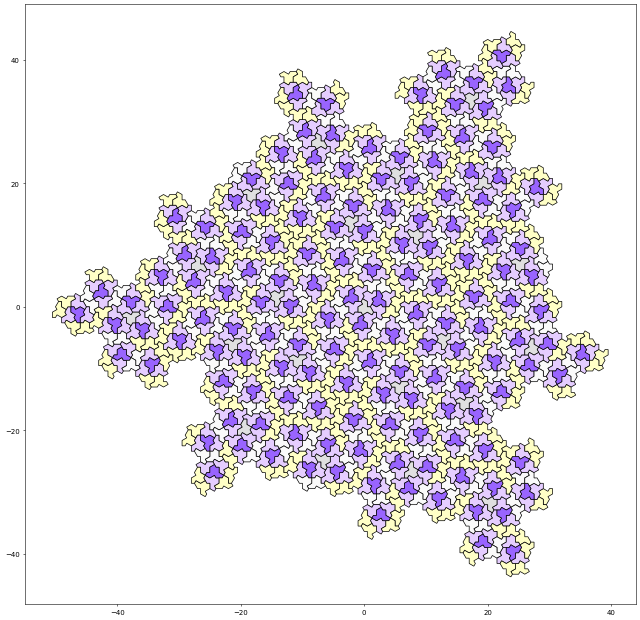

In [64]:
# MetaTile H
fig = plt.figure(figsize=(16, 12), dpi=50)
ax = fig.add_axes([0, 0, 1, 1])
tiles3[0].draw(to_screen, level=4)
ax.set_aspect('equal', adjustable='box')

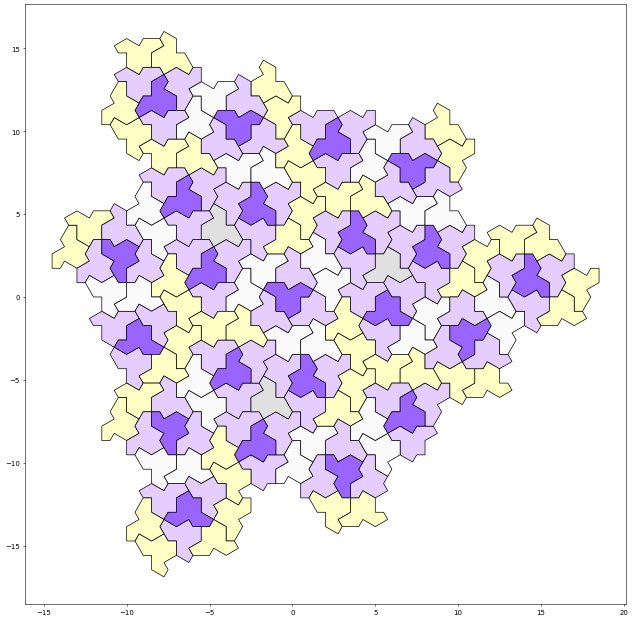

In [65]:
# MetaTile T
fig = plt.figure(figsize=(16, 12), dpi=50)
ax = fig.add_axes([0, 0, 1, 1])
tiles3[1].draw(to_screen, level=4)
ax.set_aspect('equal', adjustable='box')

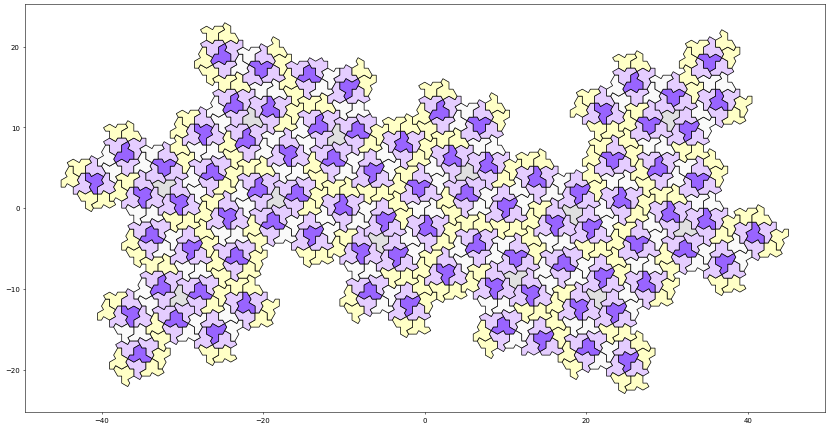

In [66]:
# MetaTile P
fig = plt.figure(figsize=(16, 12), dpi=50)
ax = fig.add_axes([0, 0, 1, 1])
tiles3[2].draw(to_screen, level=4)
ax.set_aspect('equal', adjustable='box')

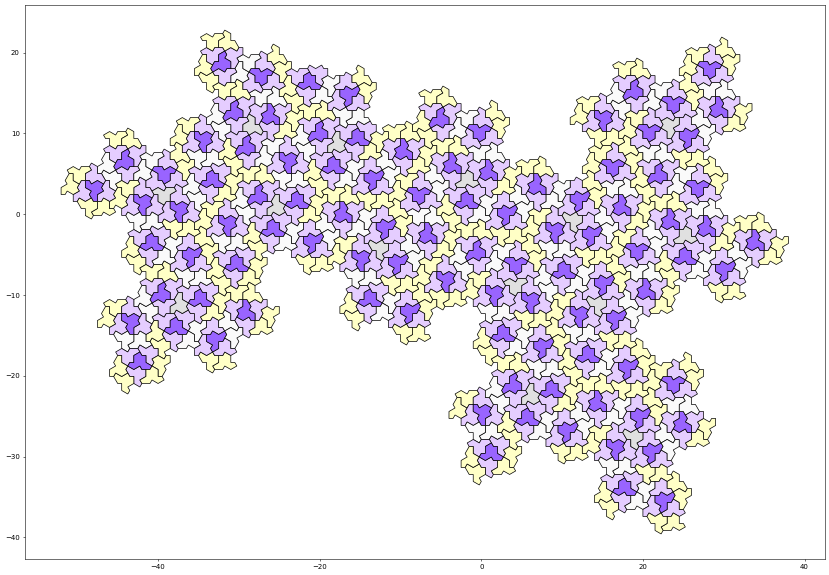

In [67]:
# MetaTile F
fig = plt.figure(figsize=(16, 12), dpi=50)
ax = fig.add_axes([0, 0, 1, 1])
tiles3[3].draw(to_screen, level=4)
ax.set_aspect('equal', adjustable='box')